In [2]:
# -*- coding: utf-8 -*-
# Create time: 2025-09-25
# Update time: 2025-11-27

# conda activate benchmark
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from typing import List
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
plt.rcParams['svg.fonttype'] = 'none'


class EmbeddingMetrics:
    def __init__(self, df: pd.DataFrame):
        """
        直接用 DataFrame 构造：
        第一行为某 embedding 的指标值，最后一行为 metric 类型
        """
        self.metric_values = df.iloc[0:1].copy()
        self.metric_types = df.iloc[1:2].copy()
        self.embedding_name = self.metric_values.index[0]

    @classmethod
    def from_file(cls, filepath: str):
        df = pd.read_csv(filepath, index_col=0)
        return cls(df)

    def get_value(self, col_name: str) -> float | None:
        """返回指定指标的数值"""
        if col_name in self.metric_values.columns:
            return float(self.metric_values[col_name].values[0])
        else:
            print(f"[Warning] 指标列 '{col_name}' 不存在。")
            return None

    def rename_embedding(self, new_name: str):
        """修改 embedding 名称"""
        self.metric_values.index = [new_name]
        self.embedding_name = new_name

    def add_column(self, col_name: str, col_type: str, value: float):
        """添加新的一列指标及其类型，按指标类型插入到对应位置"""
        if col_name in self.metric_values.columns:
            print(f"[Warning] 列 '{col_name}' 已存在，跳过添加。")
            return

        # 获取所有当前指标列
        all_cols = list(self.metric_values.columns)

        # 找到相同类型的最后一个列的索引位置
        insert_idx = None
        for i, col in enumerate(all_cols):
            if self.metric_types[col].values[0] == col_type:
                insert_idx = i + 1  # 插入到这个后面

        # 若找不到同类指标，就加到最前或最后
        if insert_idx is None:
            insert_idx = 0  # 默认插在最前（也可以改为 len(all_cols) 插最后）

        # 插入到指定位置
        for df in [self.metric_values, self.metric_types]:
            df.insert(loc=insert_idx, column=col_name, value=value if df is self.metric_values else col_type)

    def delete_column(self, col_name: str):
        """从指标中删除指定列（指标值和类型都一起删）"""
        if col_name in self.metric_values.columns:
            self.metric_values.drop(columns=[col_name], inplace=True)
            self.metric_types.drop(columns=[col_name], inplace=True)
        else:
            print(f"[Warning] 列名 '{col_name}' 不存在，跳过删除。")

    def filter_columns(self, keep_cols: List[str]):
        """
        只保留指定的指标列（指标值和类型都一起筛选）
        """
        current_cols = set(self.metric_values.columns)
        keep_set = set(keep_cols)
        drop_cols = list(current_cols - keep_set)
        self.metric_values.drop(columns=drop_cols, inplace=True)
        self.metric_types.drop(columns=drop_cols, inplace=True)

    def update_value(self, col_name: str, new_value: float):
        """更新已有指标的数值"""
        self.metric_values[col_name] = new_value

    def compute_scores(self, weights: dict = None):
        """
        自动计算三类 Aggregate Score：
        1. Bio conservation: 平均值
        2. Batch correction: 平均值
        3. Total: 加权平均
        """
        if weights is None:
            weights = {
                "Bio conservation": 0.6,
                "Batch correction": 0.4 
            }

        bio_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Bio conservation"]
        batch_cols = [c for c in self.metric_values.columns if self.metric_types[c].values[0] == "Batch correction"]

        bio_score = self.metric_values[bio_cols].astype(float).mean(axis=1).values[0] if bio_cols else 0
        batch_score = self.metric_values[batch_cols].astype(float).mean(axis=1).values[0] if batch_cols else 0

        self.metric_values["Bio conservation"] = bio_score
        self.metric_types["Bio conservation"] = "Aggregate score"

        self.metric_values["Batch correction"] = batch_score
        self.metric_types["Batch correction"] = "Aggregate score"

        total_score = bio_score * weights["Bio conservation"] + batch_score * weights["Batch correction"]
        self.metric_values["Total"] = total_score
        self.metric_types["Total"] = "Aggregate score"

    def to_dataframe(self) -> pd.DataFrame:
        return pd.concat([self.metric_values, self.metric_types])

    @staticmethod
    def merge_embeddings(objs: List["EmbeddingMetrics"]) -> pd.DataFrame:
        """
        将多个 EmbeddingMetrics 合并为一个 DataFrame：
        多行指标 + 一行 Metric Type
        """
        rows = [obj.metric_values for obj in objs]
        types = objs[0].metric_types.copy()  # 假设类型一致
        df = pd.concat(rows + [types])
        return df

def plot_results_df(df: pd.DataFrame, show: bool = True, save_dir: str | None = None,
                    fig_width_cm: float = 16, fig_height_cm: float = 10):
    """
    参数
    ----------
    df : pd.DataFrame
        多行代表不同模型，最后一行为 Metric Type。
    show : bool
        是否显示图像。
    save_dir : str | None
        若提供路径，则保存为 pdf/svg 图像。
    fig_width_cm : float
        图像宽度（厘米）。
    fig_height_cm : float
        图像高度（厘米）。
    font_size_pt : int
        全局字体大小（pt）。
    """

    # 提取最后一行作为 metric_type 行，并移除
    metric_type_row = df.loc["Metric Type"]
    df = df.drop(index="Metric Type")

    # 转 float
    df = df.astype(np.float64)

    # 指标列分类
    # 根据 metric_type_row 将列分类（aggregate score vs 其它）
    _AGGREGATE_SCORE = "Aggregate score"
    score_cols = [col for col in df.columns if metric_type_row[col] == _AGGREGATE_SCORE]
    other_cols = [col for col in df.columns if metric_type_row[col] != _AGGREGATE_SCORE]

    # 选择一个主排序列（Total > Batch correction > 第一个 score 或 第一个 other）
    # 根据该列的值对行进行排序
    if "Total" in df.columns:
        sort_col = "Total"
    elif "Batch correction" in df.columns:
        sort_col = "Batch correction"
    else:
        sort_col = score_cols[0] if score_cols else other_cols[0]
    df = df.sort_values(by=sort_col, ascending=False)

    # 记录 method 名
    # Table 的 index_col 参数将使用此列作为左侧索引显示
    df["Method"] = df.index

    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7

    # 画图设置
    # 颜色映射函数：把数值列映射到分级 colormap
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=mpl.cm.PRGn, num_stds=2.5)

    # 构建 column_definitions：告诉 Table 每一列如何显示（文本/颜色/是否绘制 bar 等）

    # 第一列是 Method（方法名），宽一点并左对齐、加粗
    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"})
    ]

    # 紧接着为 other_cols（非 aggregate score 的列）构建 column_def：
    # 这些列默认显示为带圆形背景的数值（text + 内置 bbox），并用 cmap 对数值着色
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1), # 给列名在第一个空格处换行，避免过宽
            width=1.2, # 相对宽度单位
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(df[col]),
            group=metric_type_row[col],
            formatter="{:.2f}", # 单元格内数值格式化为两位小数
        )
        for col in other_cols
    ]

    # 最后为 score_cols（Aggregate score）构建 column_def：
    # 这些列会用嵌入式小条形图（plot_fn=bar）来显示值，同时可注释数值
    column_definitions += [
        ColumnDefinition(
            col,
            width=1.2,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": mpl.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group=metric_type_row[col],
            border="left" if i == 0 else None, # 如果是第一个 score 列，左侧画一条竖线分隔
        )
        for i, col in enumerate(score_cols)
    ]

    # cm 转 inch
    cm_to_inch = 1 / 2.54

    with mpl.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(
            figsize=(fig_width_cm * cm_to_inch, fig_height_cm * cm_to_inch)
        )
        tab = Table(
            df,
            cell_kw={"linewidth": 0, "edgecolor": "k"},
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 7, "ha": "center"},
            row_divider_kw={"linewidth": 0.75, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 0.75, "linestyle": "-"},
            column_border_kw={"linewidth": 0.75, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=df.columns)

    if show:
        plt.show()

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, "scib_results.pdf"), bbox_inches="tight")
        fig.savefig(os.path.join(save_dir, "scib_results.jpg"), dpi=600, bbox_inches="tight")

    return tab


In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/liver/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/liver/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/liver/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/liver/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/liver/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/liver/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/liver/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/liver/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/liver/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/liver/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/liver/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/liver/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_liver = EmbeddingMetrics.merge_embeddings(metrics_all)

In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_assay/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_assay/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_assay/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_assay/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_assay/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_assay/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_assay/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_assay/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_hlca_assay = EmbeddingMetrics.merge_embeddings(metrics_all)

In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_disease/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_disease/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_disease/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_disease/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_disease/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_disease/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_disease/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_disease/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_hlca_disease = EmbeddingMetrics.merge_embeddings(metrics_all)

In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/HLCA_sn/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/HLCA_sn/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/HLCA_sn/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/HLCA_sn/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/HLCA_sn/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/HLCA_sn/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/HLCA_sn/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/HLCA_sn/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_hlca_sn = EmbeddingMetrics.merge_embeddings(metrics_all)

In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/Immune/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/Immune/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/Immune/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/Immune/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/Immune/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/Immune/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/Immune/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/Immune/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/Immune/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/Immune/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/Immune/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/Immune/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_immune = EmbeddingMetrics.merge_embeddings(metrics_all)

In [ ]:
files = [
    {"method": "Geneformer", "path": "/home/wanglinting/scFM/Result/limb/geneformer"},
    {"method": "scGPT", "path": "/home/wanglinting/scFM/Result/limb/scgpt"},
    {"method": "scFoundation", "path": "/home/wanglinting/scFM/Result/limb/scfoundation"},
    {"method": "CellPLM", "path": "/home/wanglinting/scFM/Result/limb/cellplm"},
    {"method": "UCE", "path": "/home/wanglinting/scFM/Result/limb/uce"},
    {"method": "PCA", "path": "/home/wanglinting/scFM/Result/limb/pca"},
    {"method": "Harmony", "path": "/home/wanglinting/scFM/Result/limb/harmony"},
    {"method": "scVI", "path": "/home/wanglinting/scFM/Result/limb/scvi"},
    {"method": "Scanorama", "path": "/home/wanglinting/scFM/Result/limb/scanorama"},
    {"method": "Nicheformer", "path": "/home/wanglinting/scFM/Result/limb/nicheformer"},
    {"method": "scCello", "path": "/home/wanglinting/scFM/Result/limb/sccello"},
    {"method": "GeneCompass", "path": "/home/wanglinting/scFM/Result/limb/genecompass"},
]

metrics_all = []

for entry in files: 
    method_name = entry["method"]
    path = entry["path"]

    file_scib = f"{path}/metrics_scIB.csv"

    m = EmbeddingMetrics.from_file(file_scib)

    # 改名
    m.rename_embedding(method_name)

    m.filter_columns(["Leiden NMI", "Leiden ARI", "Silhouette label", "BRAS", "Graph connectivity"])

    # 计算 aggregate 分数
    m.compute_scores(weights={
        "Bio conservation": 0.5,
        "Batch correction": 0.5
    })

    metrics_all.append(m)

# 合并所有模型
merged_df_limb = EmbeddingMetrics.merge_embeddings(metrics_all)

In [11]:
cm_to_inch = 1 / 2.54
def plot_total_scores_across_datasets(merged_dfs: List[pd.DataFrame], 
                                     dataset_names: List[str],
                                     show: bool = True, 
                                     save_dir: str | None = None,
                                     figsize: tuple = (16, 10)):
    """
    绘制不同数据集上各模型Total分数的折线图
    
    Parameters
    ----------
    merged_dfs : List[pd.DataFrame]
        多个数据集的merged_df列表
    dataset_names : List[str]
        数据集名称列表
    show : bool
        是否显示图像
    save_dir : str | None
        保存路径
    """
    
    # 定义模型分类
    traditional_methods = ['PCA', 'Harmony', 'scVI', 'Scanorama']
    foundation_models = ['CellPLM', 'scGPT', 'Geneformer', 'scFoundation', 'UCE', 'Nicheformer', 'scCello', 'GeneCompass']
    
    # 定义颜色和形状
    model_colors = {
        'Harmony': '#FF8E53', 
        'PCA': '#26C281',
        'Scanorama': '#FF6B6B',
        'scVI': '#4ECDC4',
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': "#DB45F9",
        'GeneCompass': "#B9CF0F",
    }

    # 定义形状
    shapes = {
        'Traditional methods': 'o',  # 圆形
        'Foundation models': 's'     # 方形
    }

    # 定义折线形状
    line_styles = {
        'Traditional methods': '-', # 实线
        'Foundation models': '--'   # 虚线
    }

    # 提取每个数据集的Total分数
    all_scores = {}
    all_models = set()
    
    for i, df in enumerate(merged_dfs):
        # 移除Metric Type行
        data_df = df.drop(index="Metric Type") if "Metric Type" in df.index else df
        
        for model in data_df.index:
            if model not in all_scores:
                all_scores[model] = []
            all_scores[model].append(data_df.loc[model, 'Total'])
            all_models.add(model)
    
    # 转换为浮点数
    for model in all_scores:
        all_scores[model] = [float(score) for score in all_scores[model]]
    
    # 设置图像

    plt.figure(figsize=figsize)
    
    # 设置字体
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 7
    
    # 为每个模型绘制折线
    for model in all_models:
        # 确定模型类别和对应的形状
        if model in traditional_methods:
            shape = shapes['Traditional methods']
            category = 'Traditional methods'
            linestyle = line_styles['Traditional methods']
        elif model in foundation_models:
            shape = shapes['Foundation models'] 
            category = 'Foundation models'
            linestyle = line_styles['Foundation models']
        else:
            shape = 'o'  # 默认形状
            category = 'Other'
            linestyle = '-'
        
        # 获取颜色
        color = model_colors.get(model, '#999999')  # 默认灰色
        
        # 绘制折线
        plt.plot(dataset_names, all_scores[model], 
                marker=shape, 
                color=color, 
                label=model,
                linestyle=linestyle,
                linewidth=1,
                alpha=0.9,
                markersize=5,
                markeredgewidth=0.1,
                markeredgecolor='white')
        
    # 设置坐标轴范围
    plt.ylim(0.4, 0.83)
    # 设置y轴刻度间隔
    plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8])

    # 设置图像属性
    plt.xlabel('Dataset (batch source)', fontsize=7)
    plt.ylabel('scIB Score', fontsize=7)
    plt.title('')

    # # x轴标签倾斜，整体向左移动
    # plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # 设置网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tick_params(axis='both', which='major', labelsize=6, pad=1)

    # 移除上方和右方框线
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, "Figure2B_scib_score.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2B_scib_score.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, "Figure2B_scib_score.jpg"), dpi=600, bbox_inches="tight")

    # 显示图像
    if show:
        plt.show()
    
    return plt.gcf()

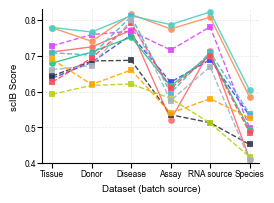

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [12]:
plot_total_scores_across_datasets(
    [merged_df_liver, merged_df_immune, merged_df_hlca_disease, merged_df_hlca_sn, merged_df_hlca_assay, merged_df_limb], 
    # ['Liver (donor)', 'Immune (tissue)', 'HLCA (disease)', 'HLCA (RNA source)', 'HLCA (assay)', 'Limb (species)'],
    ['Tissue', 'Donor', 'Disease',  'Assay', 'RNA source', 'Species'],
    show=True, 
    save_dir="/home/wanglinting/scFM/Result/figure",
    figsize=(7 * cm_to_inch,  5.2 * cm_to_inch)
)

In [15]:
from scipy import stats

def plot_params_vs_scores(merged_dfs: List[pd.DataFrame], 
                          dataset_names: List[str],
                          model_values: dict,
                          value_type: str = 'params',
                          show: bool = True, 
                          save_dir: str | None = None,
                          figsize: tuple = (16, 10)):
    """
    绘制参数量/数据量与scIB得分的散点图（2行3列子图）
    仅包含基础模型，图例在右侧
    
    Parameters
    ----------
    merged_dfs : List[pd.DataFrame]
        多个数据集的merged_df列表
    dataset_names : List[str]
        数据集名称列表
    model_values : dict
        模型名称到参数量(M)或数据量(M cells)的映射
    value_type : str
        输入类型，'params'表示参数量，'data'表示数据量
    show : bool
        是否显示图像
    save_dir : str | None
        保存路径
    figsize : tuple
        图像大小
    """
    
    # 仅定义基础模型
    foundation_models = ['CellPLM', 'scGPT', 'Geneformer', 'scFoundation', 'UCE', 'Nicheformer', 'scCello', 'GeneCompass']
    
    # 定义颜色
    model_colors = {
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': '#DB45F9',
        'GeneCompass': '#B9CF0F',
    }
    
    # 确定x轴标签
    if value_type == 'params':
        x_label = 'Model Parameters (log2(M))'
    elif value_type == 'data':
        x_label = 'Data Volume (log2(M cells))'
    else:
        x_label = 'Value (log2)'
    
    # 提取每个数据集的模型分数和参数量/数据量
    dataset_data = []
    
    for i, df in enumerate(merged_dfs):
        # 移除Metric Type行
        data_df = df.drop(index="Metric Type") if "Metric Type" in df.index else df
        
        models_scores = {}
        for model in data_df.index:
            if model in foundation_models:  # 仅保留基础模型
                score = float(data_df.loc[model, 'Total'])
                value = model_values.get(model, None)
                if value is not None:
                    # 取log2
                    value_log2 = np.log2(value)
                    models_scores[model] = {'score': score, 'value': value_log2}
        
        dataset_data.append(models_scores)

    # 创建子图 (2行3列)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # 设置全局字体
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 7
    
    # 为每个数据集绘制散点图
    for idx, (ax, dataset_name, data) in enumerate(zip(axes, dataset_names, dataset_data)):
        
        # 提取用于相关性计算的数据
        if len(data) >= 3:  # 至少需要3个数据点
            x_vals = np.array([data[model]['value'] for model in foundation_models if model in data])
            y_vals = np.array([data[model]['score'] for model in foundation_models if model in data])
            
            # 计算Pearson相关系数和p值
            if len(x_vals) >= 3:
                corr, p_value = stats.pearsonr(x_vals, y_vals)
            else:
                corr, p_value = np.nan, np.nan
        else:
            corr, p_value = np.nan, np.nan
        
        # 绘制基础模型散点
        for model in foundation_models:
            if model in data:
                ax.scatter(data[model]['value'], data[model]['score'], 
                          s=35,
                          c=model_colors.get(model, '#999999'),
                          alpha=1,
                          edgecolors='black',
                          linewidth=0.5,
                          label=model)
        
        # 设置坐标轴范围，稍微比最大最小值扩大一点
        if len(data) > 0:
            x_min = min([data[model]['value'] for model in data]) * 0.8
            x_max = max([data[model]['value'] for model in data]) * 1.2
            y_min = min([data[model]['score'] for model in data]) * 0.95
            y_max = max([data[model]['score'] for model in data]) * 1.1
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)

        # 设置坐标轴标签为空（统一显示在整个图外侧）
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        # 设置子图标题
        ax.set_title(dataset_name, fontsize=8, fontweight='bold')
        
        # 在图上方显示相关系数和p值
        if not np.isnan(corr):
            corr_text = f'r = {corr:.3f}  p = {p_value:.3f}'
            ax.text(0.95, 0.95, corr_text, transform=ax.transAxes,
                   fontsize=6, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.3))
        
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=6)
        
        # 移除上方和右方框线
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # 创建统一的图例 - 放在右侧
    legend_elements = []
    for model in foundation_models:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                        markerfacecolor=model_colors.get(model, '#999999'),
                                        markersize=8,
                                        label=model,
                                        markeredgecolor='black',
                                        markeredgewidth=0.5))
    
    fig.legend(handles=legend_elements, 
              loc='center right', 
              bbox_to_anchor=(1.12, 0.5),
              frameon=False, 
              fontsize=7,
              handletextpad=0.5,
              title_fontsize=7)
    
    # 调整布局，为右侧图例留出空间
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)
    
    # 在整个图的左侧中间添加共享ylabel
    fig.text(-0.02, 0.5, 'scIB Score', 
             va='center', ha='center', rotation='vertical', fontsize=8)
    
    # 在整个图的下方中间添加共享xlabel
    fig.text(0.5, -0.02, x_label, 
             va='center', ha='center', fontsize=8)
    
    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{value_type}_vs_scores.pdf"), bbox_inches="tight")
        fig.savefig(os.path.join(save_dir, f"{value_type}_vs_scores.jpg"), dpi=600, bbox_inches="tight")
    
    # 显示图像
    if show:
        plt.show()
    
    return None

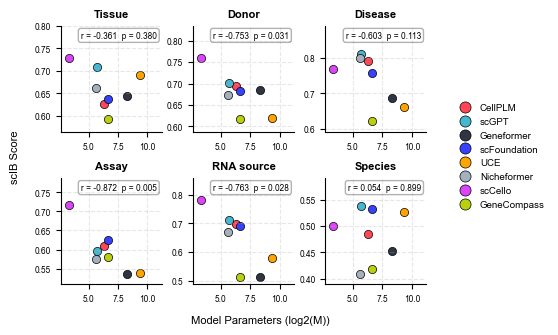

In [16]:
# 定义基础模型的参数量（单位：M）
model_parameters = {
    'Geneformer': 316,
    'scGPT': 53,
    'scFoundation': 100,
    'CellPLM': 80,
    'UCE': 650,
    'Nicheformer': 49.3,
    'scCello': 10,
    'GeneCompass': 100,
}

cm_to_inch = 1 / 2.54

# 参数量版本
plot_params_vs_scores(
    [merged_df_liver, merged_df_immune, merged_df_hlca_disease, merged_df_hlca_sn, merged_df_hlca_assay, merged_df_limb],
    ['Tissue', 'Donor', 'Disease', 'Assay', 'RNA source', 'Species'],
    model_parameters,
    value_type='params',  # 指定为参数量
    show=True,
    save_dir="/home/wanglinting/scFM/Result/figure",
    figsize=(12 * cm_to_inch, 8 * cm_to_inch)
)


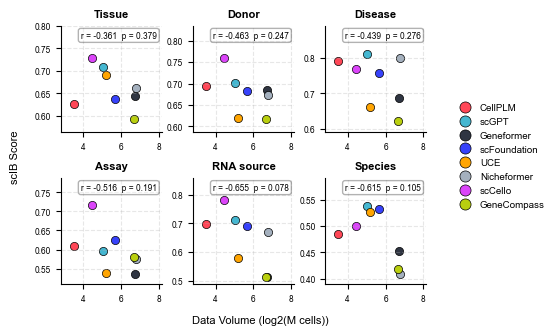

In [17]:
model_data = {
    'Geneformer': 104,
    'scGPT': 33,
    'scFoundation': 50,
    'CellPLM': 11.4,
    'UCE': 36,
    'Nicheformer': 110,
    'scCello': 22,
    'GeneCompass': 101,
}


# 数据量版本
plot_params_vs_scores(
    [merged_df_liver, merged_df_immune, merged_df_hlca_disease, merged_df_hlca_sn, merged_df_hlca_assay, merged_df_limb],
    ['Tissue', 'Donor', 'Disease', 'Assay', 'RNA source', 'Species'],
    model_data,
    value_type='data',  # 指定为数据量
    show=True,
    save_dir="/home/wanglinting/scFM/Result/figure",
    figsize=(12 * cm_to_inch, 8 * cm_to_inch)
)
